## Exercise 2 - FML


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from scipy.stats import multivariate_normal
import pandas as pd

# import os
# os.system('jupyter nbconvert --to html qda-lda.ipynb')

## 3. Data Preparation

In [2]:
from sklearn.datasets import load_digits
from sklearn import model_selection

#load data set from sklearn
digits = load_digits()
#print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# shuffle data to get rid of "ordering" in the data (for example: first ten digits were drawn by person 1 (nice handwriting), next ten were written by person 2 (bad handwriting), ... )
rng = np.random.default_rng()
idx = rng.permutation(np.arange(data.shape[0]))
X_all, y_all = data[idx], target[idx]

# filters the dataset such that only the digits "1" and "7" are left
pos = np.sort(np.append(np.where(y_all == 1), np.where(y_all == 7)))
X_filtered, y_filtered = X_all[pos], y_all[pos]
print("The filtered data set has %i instances." %len(X_filtered))

# split data set into training and test set
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(X_filtered, y_filtered, test_size = 0.4, random_state = 0)


The filtered data set has 361 instances.


<span style="color:green; font-weight: bold">COMMENTS: 
Essentially the same with sample solution, except it would be better if using "data_preperation" as a function for later convenience.</span>

### 3.1 Dimension Reduction

In [3]:
def normalize(x):
    # function that normalizes features 
    x = (x-np.amin(x))/(np.amax(x)-np.amin(x))
    return x

def reduce_dim(X):
    # features 1 (f1: diagonal gradients) and 2 (f2: column gradients):
    f1 = [] #Tiltiness
    f2 = [] #Straightness

    # loop over all images in data set:
    for n in range(len(X)):
        # reshape images to get symmetric matrices:
        img = np.reshape(X[n], (8,8))

        # get all diagonals of the input matrices (from lower left to upper right):
        diags = [img[::-1,:].diagonal(i) for i in range(-img.shape[0]+2,img.shape[0]-1)]
        # sum of all (absolute) gradient values between adjacent pixels on diagonals:
        f1.append(np.sum([np.sum(np.abs(np.gradient(diags[i]))) for i in range(len(diags))]))

        # get all columns of image matrices:
        cols = np.hsplit(img, 1)
        # sum of all (absolute) gradient values across each column in image matrices:
        f2.append(np.sum([np.sum(np.abs(np.gradient(cols[i]))) for i in range(len(cols))]))

    return list(zip(1-normalize(f1), 1-normalize(f2)))


<span style="color:green; font-weight: bold">COMMENTS: Your solution to reduce the feature dimension is brillant! We like it! Well done!
</span>

### 3.2 Scatterplot

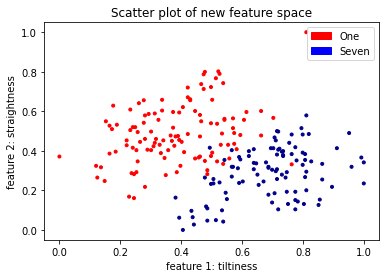

In [4]:
# apply dimensionality reduction on the training features
X_train_reduced = np.array(reduce_dim(X_train)) 

# reorder results into panda data frame structure
df = pd.DataFrame(dict(tiltiness=X_train_reduced[:,0], straightness=X_train_reduced[:,1], label=y_train))

# scatter plot of training data in new feature space 
plt.scatter(df["tiltiness"], df["straightness"], c=df["label"].map({1:"red", 7:"darkblue"}), marker=".")
plt.xlabel("feature 1: tiltiness")
plt.ylabel("feature 2: straightness")
plt.title("Scatter plot of new feature space")
red_patch = mpatches.Patch(color='red', label='One')
blue_patch = mpatches.Patch(color='blue', label='Seven')
plt.legend(handles=[red_patch, blue_patch], loc="best")
plt.show()

Our two features seem to be not perfect but also not too bad! So given that they should not be too perfect, this seems to be alright. It is clearly visible that the "7"s (on average) have a higher "tiltiness" and a lower "straigtness" than the "1"s.  

<span style="color:green; font-weight: bold">COMMENTS: We like the way you plot, your plot is very informative!</span>

## 4. Nearest Mean
### 4.1 Implement the nearest mean classifier

In [5]:
def dist_vec(training, test):
    # function computes the euclidean distance between two points (training and test)
    dist = -2*np.dot(test, training.T) + np.sum(training**2) + np.sum(test**2)
    return np.sqrt(dist.T)


def nearest_mean(training_features, training_labels, test_features):
    # function that finds the mean of the 2D feature vectors of each class in the training set and assign the label of its nearest mean to each test instance
    labels = []
    mean_classes = []
    # loop through each class
    for label in np.unique(training_labels):
        labels.append(label)
        X_train = training_features[np.where(training_labels == label)]
        #compute mean
        mean_classes.append(np.mean(X_train, axis=0))

    predicted_labels  = []
    for x_test in test_features:
        # compute distances between means and data points
        dist_to_means = [dist_vec(mean_classes[m], x_test) for m in range(len(labels))]
        pos = dist_to_means.index(min(dist_to_means))
        predicted_labels.append(labels[pos])
            
    return mean_classes, predicted_labels 

def prediction_error(truth, prediction):
    # compare the arrays element-wise
    err = 1-np.count_nonzero(np.equal(truth, prediction))/len(truth)
    return err*100

<span style="color:green; font-weight: bold">COMMENTS: Essentially the same as the sample solution.</span>

### 4.2 Visualize the decision regions

The test error rate using Nearest Mean is 13.793 percent.


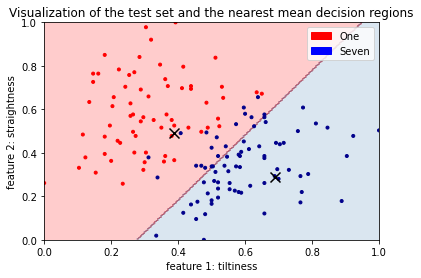

In [6]:
# apply dimensionality reduction to the feature sets 
X_train_reduced = np.array(reduce_dim(X_train))
X_test_reduced = np.array(reduce_dim(X_test))

# apply nearest mean classifier on test features
mean_classes, predicted_labels = nearest_mean(X_train_reduced, y_train, X_test_reduced)
# print test error rate
print("The test error rate using Nearest Mean is %.3f percent." %prediction_error(y_test, predicted_labels))

# structure ground truth
df = pd.DataFrame(dict(tiltiness=X_test_reduced[:,0], straightness=X_test_reduced[:,1], label=y_test))

# compute meshgrid
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
pred = np.array(nearest_mean(X_train_reduced, y_train, np.c_[xx.ravel(), yy.ravel()])[1]).reshape(xx.shape)

# plot decision regions of nearest mean classifier with scatter plot of the ground truth
plt.contourf(xx, yy, pred, alpha=0.2, colors = ["red", "steelblue"])
plt.scatter(df["tiltiness"], df["straightness"], c=df["label"].map({1:"red", 7:"darkblue"}), marker=".")
plt.scatter(np.array(mean_classes)[:,0], np.array(mean_classes)[:,1], marker="x", color="k", s=100)
plt.xlabel("feature 1: tiltiness")
plt.ylabel("feature 2: straightness")
plt.title("Visualization of the test set and the nearest mean decision regions")
plt.ylim(0,1)
plt.xlim(0,1)
red_patch = mpatches.Patch(color='red', label='One')
blue_patch = mpatches.Patch(color='blue', label='Seven')
plt.legend(handles=[red_patch, blue_patch], loc="best")
plt.show()


The test error rate of our nearest mean classifier is around 11%. As visible in the plot above, this can be improved. The decision boundary seems to not be perfectly placed.  

<span style="color:green; font-weight: bold">COMMENTS: The chart is more or less in line with the sample solution. Good job!</span>

## 5. QDA

### 5.1 Implement QDA Training

In [7]:
def fit_qda(training_features, training_labels):

    _, counts = np.unique(training_labels, return_counts=True)
    N0, N1 = counts[0], counts[1]

    # priors of both classes:
    p = np.array([N0/len(training_labels), N1/len(training_labels)])

    # matrix mean:
    pos0, pos1= np.where(training_labels==1), np.where(training_labels==7)
    x0, x1 = training_features[pos0], training_features[pos1]

    mean0 = np.mean(x0, axis=0)
    mean1 = np.mean(x1, axis=0)
    mu = np.array([mean0, mean1])

    # covariance matrix:
    cov0 = 1/N0*np.dot((x0-mean0).T,(x0-mean0))
    cov1 = 1/N1*np.dot((x1-mean1).T,(x1-mean1))
    covmat = np.array([cov0, cov1])

    return mu, covmat, p

<span style="color:green; font-weight: bold">COMMENTS: Silightly different from the solution : the 'fit_qda' function should work for arbitrary feature dimension, while yours can only work when class is 1 and 7. </span>

### 5.2 Implement QDA Prediction

In [132]:
def predict_qda(mu, covmat, p, test_features):
    # function that uses the output of fit_qda and uses QDA to predict the labels (0:1 and 1:7) for a matrix of test_features
    loss = []
    for i in range(len(p)):
        dist = []
        # definitions for b and mahalanobis distance were given in lecture
        b = 1/2*np.log(np.linalg.det(2*np.pi*covmat[i]))-np.log(p[i])
        for x in test_features:
            mahalanobis_dist = 1/2*np.linalg.multi_dot([(x-mu[i]), np.linalg.inv(covmat[i]), (x-mu[i]).T])
            dist.append(mahalanobis_dist+b)
        loss.append(np.array(dist))
    
    losses = np.array(list(zip(loss[0], loss[1])))
    # search for the label with the smallest loss (argmin)
    predicted_labels = np.argmin(losses, axis=1)

    # the output is 0 for digit "1" and 1 for digit "7"
    return predicted_labels

In [133]:
# compute means, covariance matrices and priors with fit_qda
mu, covmat, p = fit_qda(X_train_reduced, y_train)

# dictionary to rename label 0 to digit "1" and 1 to "7"
dictionary = {0:1,1:7}

# compute test and training error rate using function prediction_error
y_pred = np.vectorize(dictionary.get)(predict_qda(mu, covmat, p, X_test_reduced))
print("The test error rate using QDA is %.3f percent." %prediction_error(y_test, y_pred))

y_pred = np.vectorize(dictionary.get)(predict_qda(mu, covmat, p, X_train_reduced))
print("The training error rate using QDA is %.3f percent." %prediction_error(y_train, y_pred))

The test error rate using QDA is 8.966 percent.
The training error rate using QDA is 4.167 percent.


Using QDA the test error rate was reduced in comparison to the nearest mean error. The training error is even smaller than the test error, however this was expected, as the QDA classifier was trained on this data. The QDA is not perfect (error->0), as the clusters are not totally seperable.  

<span style="color:green; font-weight: bold">COMMENTS: Same with the sample solution. The way you relabel the class '1' and '7' by using dictionary is smart! </span>

### 5.3 Visualization

In [134]:
# compute meshgrid
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

# training data
df = pd.DataFrame(dict(tiltiness=X_train_reduced[:,0], straightness=X_train_reduced[:,1], label=y_train))

# compute Gaussian overlay using scipy.stats
gauss0 = np.array(multivariate_normal.pdf(np.c_[xx.ravel(), yy.ravel()], mu[0], covmat[0])).reshape(xx.shape)
gauss1 = np.array(multivariate_normal.pdf(np.c_[xx.ravel(), yy.ravel()], mu[1], covmat[1])).reshape(xx.shape)

# eigenvalue/eigenvector decomposition
w0, v0 = np.linalg.eig(covmat[0])
w1, v1 = np.linalg.eig(covmat[1])

# compute decision boundary
pred = np.vectorize(dictionary.get)(predict_qda(mu, covmat, p, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

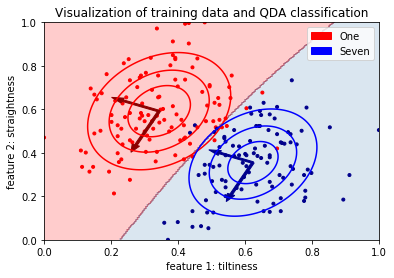

In [135]:
# plot meshgrid and scatter plot of training data

plt.contourf(xx, yy, pred, alpha=0.2, colors = ["red", "steelblue"])
plt.contour(xx, yy, gauss0, levels=3, colors="red")
plt.contour(xx, yy, gauss1, levels=3, colors="blue")

for i in range(len(w0)):
    plt.arrow(mu[0][0], mu[0][1], np.array(v0[:,i]*np.sqrt(w0[i]))[0], np.array(v0[:,i]*np.sqrt(w0[i]))[1], width=0.008, color="darkred")
for i in range(len(w1)):
    plt.arrow(mu[1][0], mu[1][1], np.array(v1[:,i]*np.sqrt(w1[i]))[0], np.array(v1[:,i]*np.sqrt(w1[i]))[1], width=0.008, color="darkblue")

plt.scatter(df["tiltiness"], df["straightness"], c=df["label"].map({1:"red", 7:"darkblue"}), marker=".")
plt.xlabel("feature 1: tiltiness")
plt.ylabel("feature 2: straightness")
plt.title("Visualization of training data and QDA classification")
plt.ylim(0,1)
plt.xlim(0,1)
red_patch = mpatches.Patch(color='red', label='One')
blue_patch = mpatches.Patch(color='blue', label='Seven')
plt.legend(handles=[red_patch, blue_patch], loc="best")
plt.show()

As visible in the plot above the QDA classifier performs better than the nearest mean classifier. However, as our data ist not totally seperable there is still some misclassification. This could be approved, of course, by choosing better features when reducing the dimensionality of the data. It is futher noticeable, that the gaussians are quite similar and the QDA boundary resembles a straight line, which is a result of our feature space. Therefore it can be expected that the prediciton errors will be similar when using the LDA classifier.

<span style="color:green; font-weight: bold">COMMENTS:
<br> * It will be better if your plot can fit different grid size in terms of different data sets like what the sample solution does.
<br> * You can also try the contours with the cluster shape of exponential log_likelihood in sample solution, which seems more clear and nicer.
</span>

### 5.4 Performance evaluation

In [136]:
def split_folds(X_all, y_all, L):
    # create random indices set and shuffle
    rng = np.random.default_rng()
    indices = np.arange(y_all.shape[0])
    indices_shuffled = rng.permutation(indices)

    # apply shuffling on all data
    X_all = X_all[indices_shuffled]
    y_all = y_all[indices_shuffled]

    # split array in roughly equal subsets
    X_folds = np.array_split(X_all, L)
    y_folds = np.array_split(y_all, L)
    return np.array(X_folds), np.array(y_folds)

def cross_validation_qda(X_all, y_all, L):
    X_split, y_split = split_folds(X_all, y_all, L)
    errors = np.array([])
    #iterate from l=1 to l=L:   
    for l in range(L):
        # use set l as test set and remaining as training sets:
        X_test, y_test = np.array(X_split[l]), y_split[l]
        X_train = np.array(np.concatenate(np.append(X_split[0:l], X_split[l+1:])))
        y_train = np.concatenate(np.append(y_split[0:l], y_split[l+1:]))

        # calculate predictions using implemented fit_qda and predict_qda classifier:
        mu, covmat, p = fit_qda(X_train, y_train)
        dictionary = {0:1,1:7} # labels must be translated {0:1, 1:7}
        y_pred = np.vectorize(dictionary.get)(predict_qda(mu, covmat, p, X_test)) 

        # calculate prediction errors:
        err = prediction_error(y_test, y_pred)
        errors = np.append(errors, err)

    #calculate mean and standard deviation of prediction error:
    err_mean = np.mean(errors)
    err_std = np.std(errors)
    return err_mean, err_std


In [137]:
# apply dimensionality reduction to whole "filtered" (only 1s and 7s) feature data
X_filtered_reduced = np.array(reduce_dim(X_filtered))
print("Using 10-fold cross validation the mean test error is (%.2f +- %.2f) percent for QDA." %cross_validation_qda(X_filtered_reduced, y_filtered, 10))

Using 10-fold cross validation the mean test error is (4.44 +- 2.84) percent for QDA.


The mean test error is smaller than the test error computet in 5.2. The standard deviation is quite high, which might be due to the fact that our features (tiltiness and straightness) are not quite robust. Nevertheless, the results are satisfying.

<span style="color:green; font-weight: bold">COMMENTS:
Code is clear and the result is great. Great job!
</span>

### 6. LDA

### 6.1/2 Implement LDA Training and Prediction

In [138]:
def fit_lda(training_features, training_labels):

    _, counts = np.unique(training_labels, return_counts=True)
    N0, N1 = counts[0], counts[1]

    # priors of both classes:
    p = np.array([N0/len(training_labels), N1/len(training_labels)])

    # matrix mean:
    pos0, pos1= np.where(training_labels==1), np.where(training_labels==7)
    x0, x1 = training_features[pos0], training_features[pos1]

    mean0 = np.mean(x0, axis=0)
    mean1 = np.mean(x1, axis=0)
    mu = np.array([mean0, mean1])

    # within-class covariance matrix:
    cov0 = np.array(np.dot((x0-mean0).T,(x0-mean0)))
    cov1 = np.array(np.dot((x1-mean1).T,(x1-mean1)))
    within_covmat = 1/(N0+N1)*(cov0+cov1)

    return mu, within_covmat, p


def predict_lda(mu, within_covmat, p, test_features):
    # function that uses the output of fit_qda and uses LDA to predict the labels (0:1 and 1:7) for a matrix of test_features
    gain = []
    for i in range(len(p)):
        dist = []
        # definitions for b and mahalanobis distance were given in lecture
        b = 1/2*np.log(np.linalg.det(2*np.pi*within_covmat))-np.log(p[i])+1/2*np.linalg.multi_dot([mu[i], np.linalg.inv(within_covmat), mu[i].T])
        for x in test_features:
            dist.append(np.linalg.multi_dot([mu[i], np.linalg.inv(within_covmat), x.T])-b)
        gain.append(np.array(dist))
    
    gains = np.array(list(zip(gain[0], gain[1])))
    # search for the label with the highest gain (argmax)
    predicted_labels = np.argmax(gains, axis=1)

    return predicted_labels


In [139]:
# compute means, within-covariance matrix and priors with fit_lda
mu, within_covmat, p = fit_lda(X_train_reduced, y_train)

# compute test and training error rate using function prediction_error
y_pred = np.vectorize(dictionary.get)(predict_lda(mu, within_covmat, p, X_test_reduced))
print("The test error rate using LDA is %.3f percent." %prediction_error(y_test, y_pred))

y_pred = np.vectorize(dictionary.get)(predict_lda(mu, within_covmat, p, X_train_reduced))
print("The training error rate using LDA is %.3f percent." %prediction_error(y_train, y_pred))

The test error rate using LDA is 8.966 percent.
The training error rate using LDA is 4.630 percent.


Compared to the errors yielded by QDA the errors resulting from the LDA classifier are compareable. However, since our features are not quite "elliptical" and not clearly separable this was expected. It was not possible to show the full potential of QDA in comparison to LDA because of our feature space.

### 6.3 Visualization

In [140]:
# compute meshgrid
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

# training data
df = pd.DataFrame(dict(tiltiness=X_train_reduced[:,0], straightness=X_train_reduced[:,1], label=y_train))

# compute Gaussian overlays using scipy.stats
gauss0 = np.array(multivariate_normal.pdf(np.c_[xx.ravel(), yy.ravel()], mu[0], within_covmat)).reshape(xx.shape)
gauss1 = np.array(multivariate_normal.pdf(np.c_[xx.ravel(), yy.ravel()], mu[1], within_covmat)).reshape(xx.shape)

# eigenvalue/eigenvector decomposition
w, v = np.linalg.eig(within_covmat)

# compute decision boundary
pred = np.vectorize(dictionary.get)(predict_lda(mu, within_covmat, p, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

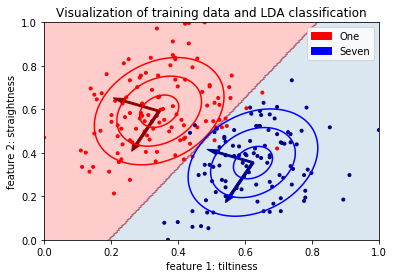

In [141]:
# plot meshgrid and scatter plot of training data
plt.contourf(xx, yy, pred, alpha=0.2, colors=["red", "steelblue"])
plt.contour(xx, yy, gauss0, colors="red", levels=3)
plt.contour(xx, yy, gauss1, colors="blue", levels=3)

for i in range(len(w)):
    plt.arrow(mu[0][0], mu[0][1], np.array(v[:,i]*np.sqrt(w[i]))[0], np.array(v[:,i]*np.sqrt(w[i]))[1], width=0.008, color="darkred")
for i in range(len(w)):
    plt.arrow(mu[1][0], mu[1][1], np.array(v[:,i]*np.sqrt(w[i]))[0], np.array(v[:,i]*np.sqrt(w[i]))[1], width=0.008, color="darkblue")

plt.scatter(df["tiltiness"], df["straightness"], c=df["label"].map({1:"red", 7:"darkblue"}), marker=".")
plt.xlabel("feature 1: tiltiness")
plt.ylabel("feature 2: straightness")
plt.title("Visualization of training data and LDA classification")
plt.ylim(0,1)
plt.xlim(0,1)
red_patch = mpatches.Patch(color='red', label='One')
blue_patch = mpatches.Patch(color='blue', label='Seven')
plt.legend(handles=[red_patch, blue_patch], loc="best")
plt.show()

The LDA classifier uses the within-covariance matrix for both classes. This of course result in more missclassification compared to QDA if the covariances are not equal. In our feature space, however, the clusters are so similar, this effect is not as strong as expected. It is possible that the difference would have been stronger when choosing other features in the dimensionality reduction.

### 6.4 Performance evaluation

In [142]:
def cross_validation_lda(X_all, y_all, L):
    X_split, y_split = split_folds(X_all, y_all, L)
    errors = np.array([])
    # iterate from l=1 to l=L:   
    for l in range(L):
        # use set l as test set and remaining as training sets:
        X_test, y_test = np.array(X_split[l]), y_split[l]
        X_train = np.array(np.concatenate(np.append(X_split[0:l], X_split[l+1:])))
        y_train = np.concatenate(np.append(y_split[0:l], y_split[l+1:]))

        # calculate predictions using implemented fit_qda and predict_qda classifier:
        mu, covmat, p = fit_lda(X_train, y_train)
        dictionary = {0:1,1:7} # labels must be translated {0:1, 1:7}
        y_pred = np.vectorize(dictionary.get)(predict_lda(mu, within_covmat, p, X_test)) 

        # calculate prediction errors:
        err = prediction_error(y_test, y_pred)
        errors = np.append(errors, err)

    # calculate mean and standard deviation of prediction error:
    err_mean = np.mean(errors)
    err_std = np.std(errors)
    return err_mean, err_std

# compute and print result of cross validation using filtered data
print("Using 10-fold cross validation the mean test error is (%.2f +- %.2f) percent for LDA." %cross_validation_lda(X_filtered_reduced, y_filtered, 10))

Using 10-fold cross validation the mean test error is (5.82 +- 3.16) percent for LDA.


The performance of the LDA classifier is slightly worse than the performance of the QDA classifier. The reasons were already discussed. 

<span style="color:green; font-weight: bold">COMMENTS:
Basic similar with the comments above. You've done an excellent job!
</span>